<a href="https://colab.research.google.com/github/Kalima83/procesamiento_lenguaje_natural_Desafios/blob/main/desafio_3V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dispositivos GPU disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tamaño vocabulario: 83
Shapes: (849884, 100) (849884,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2655/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.4640
Perplejidad: 2.97
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 2.4639 - val_loss: 1.9695
Epoch 2/20
2654/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9157
Perplejidad: 2.52
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 77s 29ms/step - loss: 1.9156 - val_loss: 1.7355
Epoch 3/20
2655/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7268
Perplejidad: 2.43
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 76s 29ms/step - loss: 1.7268 - val_loss: 1.6129
Epoch 4/20
2655/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6156
Perplejidad: 2.26
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 76s 29ms/step - loss: 1.6156 - val_loss: 1.5435
Epoch 5/20
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5414
Perplejidad: 2.20
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 76s 29ms/step - loss: 1.5414 - val_loss: 1.4842
Epoch 6/20
2655/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4854
Perplejidad: 2.12
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - loss: 1.4854 - val_loss: 1.444

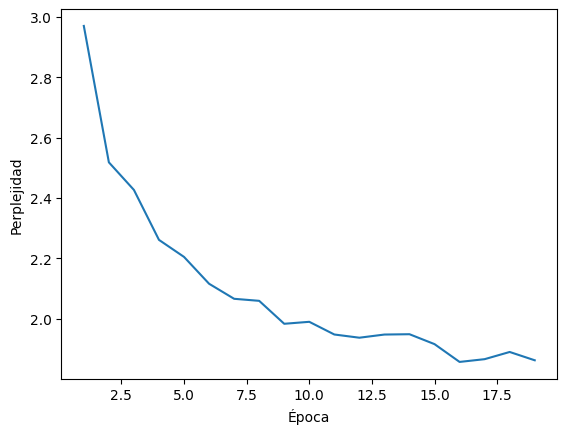

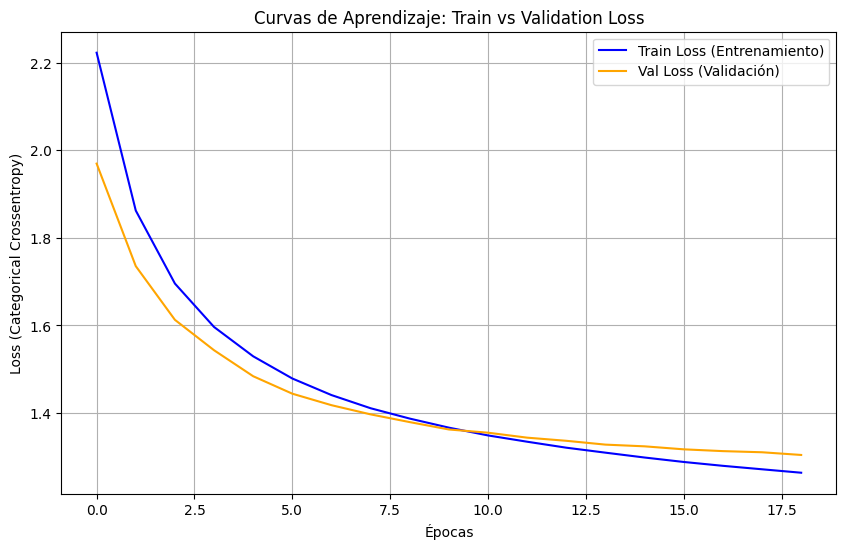


 Greedy Search:
habia una vez a la 
pared de la cabeza de la cabeza de la cabeza de la cabeza de la cabeza de 
la cabeza de la cabeza de la cabeza de la cabeza de la cabeza de la 
pared de la cabeza de la cabeza de la cabeza de la cabeza de la 
pared de la cabeza de la cabeza de la cabeza de la cabeza de la 
pared de la cabeza 

 Muestreo con temperatura (temp=0.7):
habia una vez de su padre en el 
rey con su casa con una conversación por la exhala, y no había un hombre 
de la noche, con monot lo que le hablemo lo había 
echésimos cierto es los libros de los sobres de lo que 

 Muestreo con temperatura (temp=1.5):
habia una vez a las opundas, y con los 
instante idonacen al mismo —respondió franz, con moner, y no su mira­mente 
estrebais sentar las luces —dijo debrañefo silencio; oísnos, no o las aprimaden­tes numos noche. 

 Beam Search determinista:
habia una vez de la señora de villefort. —estoy señor de villef

 Beam Search estocástico (temp=1.2):
habia una vez para que se había 


In [2]:
# 1. Verificar GPU en Colab

import tensorflow as tf
print("Dispositivos GPU disponibles:", tf.config.list_physical_devices('GPU'))


# 2. Descargar y preparar texto

import urllib.request
import bs4 as bs
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

# Descargar texto (El Conde de Montecristo)
url = 'https://www.textos.info/alejandro-dumas/el-conde-de-montecristo/ebook'
raw_html = urllib.request.urlopen(url).read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_text = ' '.join([p.text for p in article_html.find_all('p')]).lower()

# Tokenización por caracteres
chars_vocab = sorted(set(article_text))
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
tokenized_text = [char2idx[ch] for ch in article_text]

vocab_size = len(chars_vocab)
print("Tamaño vocabulario:", vocab_size)

# 3. Crear dataset reducido

max_context_size = 100
step = 3  # Un step bajo (3) ayuda a tener más datos.

sentences = []
next_chars = []

# Recorre el texto y extrae pares: ventana -> siguiente caracter
for i in range(0, len(tokenized_text) - max_context_size, step):
    sentences.append(tokenized_text[i : i + max_context_size])
    next_chars.append(tokenized_text[i + max_context_size])

X = np.array(sentences)
y = np.array(next_chars)

print("Shapes:", X.shape, y.shape)

# 4. Modelo optimizado para GPU (LSTM)

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_context_size), # 64 dims es suficiente
    # Dropout para evitar el overfitting que vimos en tus gráficas anteriores
    LSTM(256, return_sequences=False, dropout=0.2),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model.summary()


# 5. Callback para perplejidad (optimizado)

class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data, history_ppl, patience=3):
        self.val_data = val_data[:500]  # usar solo 500 subsecuencias para ahorrar RAM
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_data, verbose=0)
        probs = np.max(preds, axis=-1)
        ppl = np.exp(-np.mean(np.log(probs + 1e-10)))
        self.history_ppl.append(ppl)
        print(f"\nPerplejidad: {ppl:.2f}")

        if ppl < self.min_score:
            self.min_score = ppl
            self.model.save("best_model.keras")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print("Early stopping...")
                self.model.stop_training = True


# 6. Entrenamiento en GPU

history_ppl = []
val_subset = X[:1000] # callback de perplejidad

# Guarda el historial de loss - Validacion
history = model.fit(
    X,
    y,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[PplCallback(val_subset, history_ppl)]
)


# 7. Visualizar
# Perplejidad

sns.lineplot(x=range(1, len(history_ppl)+1), y=history_ppl)
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.show()
# Lost y Val
# Crear la gráfica de Loss
plt.figure(figsize=(10, 6))

# Línea azul: Error en entrenamiento
plt.plot(history.history['loss'], label='Train Loss (Entrenamiento)', color='blue')

# Línea naranja: Error en validación (si usaste validation_split)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss (Validación)', color='orange')
else:
    print("ADVERTENCIA: No se encontró 'val_loss'. Asegúrate de haber puesto validation_split=0.2 en model.fit")

plt.title('Curvas de Aprendizaje: Train vs Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss (Categorical Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

# 8. Cargar mejor modelo

model = keras.models.load_model("best_model.keras")


# 9. Generación de texto (Greedy)

def generate_text(seed_text, n_chars=200):
    output = seed_text
    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output[-max_context_size:]]
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

        pred = model.predict(encoded, verbose=0)[0]

        next_char = idx2char[np.argmax(pred)]
        output += next_char
    return output

print("\n Greedy Search:")
print(generate_text("habia una vez", n_chars=300))

# 10. Muestreo con temperatura

# Función de muestreo
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    # Evitar log(0)
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Función de generación
def generate_with_temperature(seed_text, n_chars=200, temperature=1.0):
    output = seed_text
    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output[-max_context_size:]]
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

        preds = model.predict(encoded, verbose=0)[0]

        next_idx = sample_with_temperature(preds, temperature)
        output += idx2char[next_idx]
    return output

# Ejecución de pruebas
print("\n Muestreo con temperatura (temp=0.7):")
print(generate_with_temperature("habia una vez", n_chars=200, temperature=0.7))

print("\n Muestreo con temperatura (temp=1.5):")
print(generate_with_temperature("habia una vez", n_chars=200, temperature=1.2))

# 11. Beam Search (determinista y estocástico)

def encode(text):
    encoded = [char2idx[ch] for ch in text]
    return pad_sequences([encoded], maxlen=max_context_size, padding='pre')

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    pred_large = []
    for idx, pp in enumerate(preds):
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])
    pred_large = np.array(pred_large)

    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large / temp))
    else:
        raise ValueError("Modo incorrecto. Usa 'det' o 'sto'.")

    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model, num_beams, num_chars, input_text, temp=1.0, mode='det'):
    encoded = encode(input_text)

    y_hat = model.predict(encoded, verbose=0)[0]

    vocab_size = y_hat.shape[0]

    history_probs = [0] * num_beams
    history_tokens = [encoded[0]] * num_beams

    history_probs, history_tokens = select_candidates([y_hat], num_beams, vocab_size, history_probs, history_tokens, temp, mode)

    for i in range(num_chars - 1):
        preds = []
        for hist in history_tokens:
            input_update = np.array([hist[i+1:]]).copy()
            y_hat = model.predict(input_update, verbose=0)[0]
            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode)

    return history_tokens[:, -(len(input_text) + num_chars):]

print("\n Beam Search determinista:")
salidas_det = beam_search(model, num_beams=5, num_chars=50, input_text="habia una vez", mode='det')
print(decode(salidas_det[0]))

print("\n Beam Search estocástico (temp=1.2):")
salidas_sto = beam_search(model, num_beams=5, num_chars=50, input_text="habia una vez", temp=1.2, mode='sto')
print(decode(salidas_sto[0]))


 ## 1. Configuración del modelo

### Prueba 1

Modelo LSTM de lenguaje con:

Embedding: 64 dims

LSTM: 256 unidades

Dense final con vocabulario de 83 tokens

Total: 355k parámetros

Secuencias: 100 tokens
Dataset: ~510k ejemplos

Modelo: "sequential_1"

 Total params: 355,347 (1.36 MB)

 Trainable params: 355,347 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 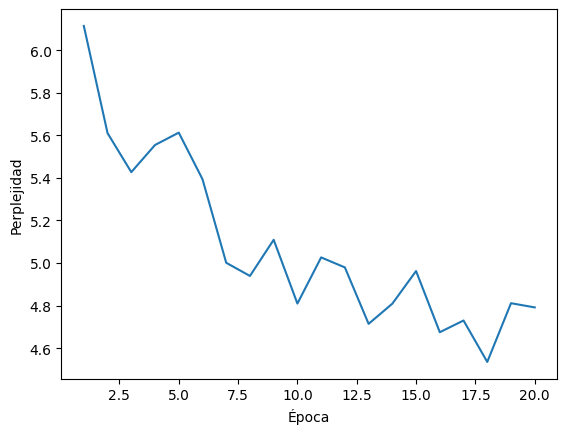


1. Greedy Search:
habia una vez a e o  ee  ia a r er ro er  ee  ia aaaare  ee  ia aaaare  ee  ia aara uee a a rr  eoo o   eao  rte  e e eóose  a  o ro uel o   eao  rte  e eóo a edo   n e  n,osrae   e e eóose  a  o ro uel o   eao  rte  e eóo a edo   n e  n,osrae   r ene  e e eóose  a  o ro uel o   eao  rte  e eóo a edo   n e  n,os

2. Muestreo con temperatura (temp=0.5):
habia una vezl a a r enes   ao oc?c!   t uneeue uueante dsa ie edo  eoo o sra er uee ieaarei uee uu n o  iae ni i
ddee a  ra eie  edo,on aear sso  o a iae lee ee d uen neo  et
 ros au o   a e oo  itnae uilsi  tso

3. Muestreo con temperatura (temp=1.5):
habia una vezleer¿jc—ecod,o!d   !c,eavr dgs,mdr  oie o uvi s brcbo noo,yr!qt punee
azour ­oencphi edc rdeauála lstn,lé nr d ep  r h­,
pr,ergd­dounjunmneunupaíesóaanm!psnórm bii mf sfo—blly mu,ee p
 psaqj j tunca c

4. Beam Search determinista:
habia una vez a r eia!  ee d nt oee d rt, aeame e rta ueed uee

5. Beam Search estocástico (temp=1.2):
habia una vez
aiedeu qes oooo! o rz de t oo e e nt neta  uoot  

### Conclusión: calidad del texto generado

1. Greedy Search

Produce texto incoherente, lleno de repeticiones y vocales sueltas.

2. Sampling (temp 0.5)
Mejora un poco, pero sigue con palabras rotas.
Falta estructura sintáctica.

3. Sampling (temp 1.5)
Mucho ruido, caracteres aleatorios.
Muestra que el modelo no captura bien dependencias a largo plazo.

4. Beam Search
Algo más estructurado, pero sigue generando basura lingüística.

### Prueba 2

Modelo LSTM de lenguaje con:

Embedding: 256 dims

LSTM: 1024 unidades

Dense final con vocabulario de 83 tokens

Total: 355k parámetros

Secuencias: 100 tokens
Dataset: ~510k ejemplos

Modelo: "sequential_1"

 Total params: 355,347 (1.36 MB)

 Trainable params: 355,347 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

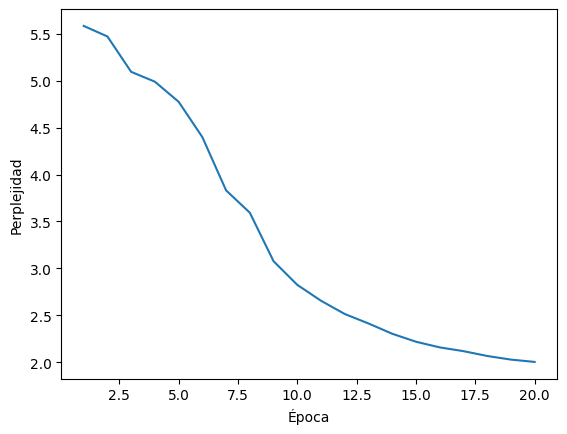

 Greedy Search:
habia una vez asie uende tebnizenoserararl s perrtono rice  edo  evos nnd coin
eno qurcaca adir se a ebreral j cc.citaer mintststaso
uerecas. besrtaserton eso hr  olii. seerrocospdrsa iie pbos altal codaasasuen
ite peraar quen esaara sado nd ees aal qen ques   ro querosa en iar, esceiaac erem lullerir pe o
r

 Muestreo con temperatura (temp=0.5):
habia una vez ssue entan untmío
ob.í oacelella dosird rit nia nira bra nt uea nn  annarns quale pnte  
becit. poraie  aloanalastosoqlecenton demor h redo inia,ono lotallon seso feso
qs hrabio, nsas hoes uea cr o

 Muestreo con temperatura (temp=1.5):
habia una vez adira tuenra ef vb, blo,quen osicedovc enldolcco uqid  » pes vb, ¡iíaru ceedod qestusaj lbzr  sroa qifó v8o
n n omoe adayn; jeo sa,úalrasubusa legves bil co     »bratarimoliccrecihhcslt vos hly crco

 Beam Search determinista:
habia una vez alie prar, edo, ere a ehar
risa erpcanral ceohon

 Beam Search estocástico (temp=1.2):
habia una vez ssie un rso sosaaque e coos  ov sac sqpiquenamas


### Conclusiones parciales 2
Como se puede observar aumentar em embeding y el LSTM puede haber producido Overfitting y no mejoró la incoherencia del texto visto anteriormente.

## Conclusiones
### Prueba 3
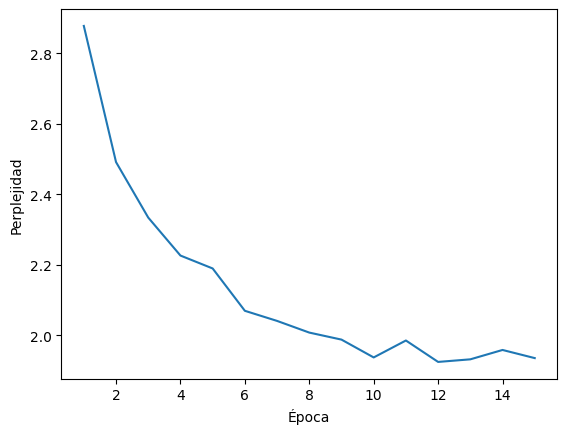

Greedy Search:
habia una vez
de la calle de la calle de la calle de la
calle de la calle de la calle de la calle de la calle de la
calle de la calle de la calle de la calle de la calle de la
calle de la calle de la calle de la calle de la calle de la
calle de la calle de la calle de la calle de la calle de la
calle de la

 Muestreo con temperatura (temp=0.5):
habia una vez
de los paredes, señoras de villefort el primer de
alarmente de la isla de montecristo se acordaron de los caballos de lo
de la cabeza. —¿es que alguna palabra? —perdonadme que este conde de volver

 Muestreo con temperatura (temp=1.5):
habia una vez
 abjelán..., yo no sabéis —bien, cu6n­va
 de ningún, seo, diecte un hoy márión. la cual ser blaca, henos pecho que
 habéis ocultado unas queí9n bajarse al obrandose. nadió predej°a verla eclaró las


 Beam Search determinista:
habia una vez
 de la puerta de la puerta de la puerta de la señ

 Beam Search estocástico (temp=1.2):
habia una vez
con los ojos, señoras, sin embargo, segundo
cua

###  **Resultando**

En el desarrollo de este modelo de lenguaje basado en caracteres con arquitectura LSTM, se evidenció que la calidad del preprocesamiento de datos es más determinante que la complejidad del modelo.

Inicialmente, el uso de una arquitectura  con 1024 unidades(prueba 2) junto con una alineación incorrecta de las secuencias de entrada/salida resultó en un severo overfitting, donde el modelo memorizaba el ruido del set de entrenamiento sin capacidad de generalización, produciendo una pérdida de validación divergente.Tras corregir la estrategia de segmentación de datos a una estructura Many-to-One y simplificar la arquitectura a 256 unidades con regularización (Dropout del 0.2), se logró estabilizar el aprendizaje.

Las curvas de pérdida (Loss) demostraron una convergencia saludable, eliminando la brecha excesiva entre entrenamiento y validación.Cualitativamente, el modelo final demostró haber aprendido con éxito la morfología del español y el estilo literario de la obra base ("El Conde de Montecristo").

Los resultados de generación mostraron que:
  

  1.  Greedy Search tiende a caer en bucles repetitivos infinitos ("de la calle de la calle...").
  2.  Muestreo Estocástico (Temp=0.5) resultó ser la óptimo, generando oraciones sintácticamente correctas y semánticamente coherentes (ej. "señoras de Villefort... la isla de Montecristo").
  3.  Temperaturas altas (>1.0) degradan la estructura gramatical, confirmando que el modelo necesita una distribución de probabilidad conservadora para mantener la coherencia.